In [1]:
%load_ext autoreload
%autoreload 2

## Important: download Pre-trained checkpoints

In order to run the four tutorials, you need to download pretrained checkpoints [here](https://drive.google.com/drive/folders/1fq0nngkeRWhCJ_CAyzQopYda20Zu-Zu8?usp=drive_link).

Replace the following with your downloaded directories

- `notebooks/inference_demo_data/real_world_pretrained_ckpts` 
- `notebooks/tutorial/tutorial_pretrained_ckpts` 

In [2]:
import sys
sys.path.append('C:/VSCode Folder/VPK/project')


In [3]:
from pathlib import Path

import torch
from hydra import initialize, compose

from neural_jacobian_field.config.common import get_typed_root_config, PipelineCfg
from neural_jacobian_field.data.data_module import DATASETS
from neural_jacobian_field.data.dataset.dataset import DatasetItems
from neural_jacobian_field.models.model import (
    Model,
    CameraInput,
    RenderingInput,
    RobotInput,
)
from neural_jacobian_field.models.model_wrapper import ModelWrapper
from neural_jacobian_field.rendering import geometry
from neural_jacobian_field.utils import convention
from neural_jacobian_field.utils.wandb_ckpt import update_checkpoint_path

C:\Users\daves\miniconda3\envs\neural-jacobian-field\lib\site-packages\nerfstudio\utils\misc.py:181: RuntimeWarning: Windows does not yet support torch.compile and the performance will be affected.
  warnings.warn(


In [4]:
from neural_jacobian_field.data.data_module import DatasetCommon

model_name = "model_toy_arm"
dataset_name = "dataset_toy_arm"
action_decoder_name = "jacobian_mlp"
checkpoint_path = "./inference_demo_data/real_world_pretrained_ckpts/m8bmmdnk/model.ckpt"

config_path = Path("project/neural_jacobian_field/configurations/config")

dataset_config_path = Path("./dataset_configs/toy_arm_config.json")

overrides = [
    f"model={model_name}",
    f"dataset={dataset_name}",
    f"dataset.root={dataset_config_path}",
    f"model.action_decoder.name={action_decoder_name}",
    f"model.rendering.num_proposal_samples=[256]",
    f"model.rendering.num_nerf_samples=256",
]

map_to_root = Path("../../")
with initialize(version_base=None, config_path=str(map_to_root / config_path.parent)):
    hydra_cfg = compose(config_name=str(config_path.name), overrides=overrides)

cfg: PipelineCfg = get_typed_root_config(hydra_cfg, PipelineCfg)

dataset: DatasetCommon = DATASETS[cfg.dataset.name](cfg=cfg.dataset, stage="train")
model = Model(cfg.model)
wrapper = ModelWrapper(cfg=cfg, model=model)

C:\Users\daves\miniconda3\envs\neural-jacobian-field\lib\site-packages\hydra\_internal\defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


WARNING: Using a slow implementation for the SHEncoding module. 

🏃 🏃 Install tcnn for speedups 🏃 🏃

pip install git+https://github.com/NVlabs/tiny-cuda-nn/#subdirectory=bindings/torch

In [5]:
checkpoint = torch.load(checkpoint_path)

wrapper.load_state_dict(checkpoint["state_dict"], strict=False)
wrapper.eval()

C:\Users\daves\miniconda3\envs\neural-jacobian-field\lib\site-packages\torch\cuda\__init__.py:215: UserWarning: 
NVIDIA GeForce RTX 5080 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5080 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


ModelWrapper(
  (model): Model(
    (encoder): EncoderResnet(
      (model): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

### Move to gpu and load near and far bounds

In [6]:
device = torch.device("cuda:0")

wrapper.to(device)
z_near = torch.tensor([dataset.near], device=device)
z_far = torch.tensor([dataset.far], device=device)
dataset_items: DatasetItems = dataset.dataset_items
ctxt_camera_index = 3
trgt_camera_index = 3


### Load camera data

In [7]:
ctxt_intrinsics, (render_height, render_width) = dataset.load_intrinsics(
    ctxt_camera_index
)
trgt_intrinsics, _ = dataset.load_intrinsics(trgt_camera_index)

ctxt_intrinsics = ctxt_intrinsics.to(device)
trgt_intrinsics = trgt_intrinsics.to(device)

ctxt_extrinsics = dataset.load_extrinsics(ctxt_camera_index).to(device)
trgt_extrinsics = dataset.load_extrinsics(trgt_camera_index).to(device)

ctxt_extrinsics, trgt_extrinsics = dataset.get_relative_transform(
    ctxt_extrinsics, trgt_extrinsics
)
coordinates, _ = geometry.get_pixel_coordinates(
    height=render_height, width=render_width, device=device
)

ctxt_extrinsics = ctxt_extrinsics.unsqueeze(0)
trgt_extrinsics = trgt_extrinsics.unsqueeze(0)

ctxt_intrinsics = ctxt_intrinsics.unsqueeze(0)
trgt_intrinsics = trgt_intrinsics.unsqueeze(0)

### Load example input image

In [8]:
from neural_jacobian_field.utils.io_utils import numpy_to_torch_image, load_numpy_image

image_filename = Path("./inference_demo_data/toy_arm_observation.png")
input_image_np = load_numpy_image(image_filename)
input_image_th = numpy_to_torch_image(input_image_np).to(device)[None]

print(input_image_th.shape)

torch.Size([1, 3, 480, 640])


In [9]:
image_height, image_width = input_image_th.shape[-2:]

origins, directions, z_values = geometry.get_world_rays_with_z(
    coordinates.view(1, -1, 2),
    trgt_intrinsics,
    trgt_extrinsics,
)

### Volume render the Jacobian Fields 

- This step is slow because of volume rendering. However, note that **volume rendering is only necessary for visualization purposes**. 
- For control purposes, gradient-based optimization of robot commands can be run at 12 hz and real-time if least square solver is used.


In [10]:
action_dim = model.decoder.action_dim
robot_action_th = torch.zeros((1, action_dim), device=device)

In [11]:
with torch.no_grad():
    rendering_outputs = model.patch_render(
        camera_input=CameraInput(
            input_image=input_image_th,
            ctxt_extrinsics=ctxt_extrinsics,
            ctxt_intrinsics=ctxt_intrinsics,
            trgt_extrinsics=trgt_extrinsics,
            trgt_intrinsics=convention.denormalize_intrinsics(
                trgt_intrinsics, width=image_width, height=image_height
            ),
        ),
        rendering_input=RenderingInput(
            origins=origins,
            directions=directions,
            z_near=z_near + torch.ones_like(z_near) * 0.15,
            z_far=torch.ones_like(z_far) * 3.2,
        ),
        robot_input=RobotInput(
            robot_action=robot_action_th,
        ),
        verbose=True,
    )

  0%|          | 0/150 [00:00<?, ?it/s]

  1%|          | 1/150 [00:01<04:11,  1.69s/it]

  1%|▏         | 2/150 [00:01<02:05,  1.17it/s]

  2%|▏         | 3/150 [00:02<01:25,  1.71it/s]

  3%|▎         | 4/150 [00:02<01:07,  2.18it/s]

  3%|▎         | 5/150 [00:02<00:56,  2.57it/s]

  4%|▍         | 6/150 [00:03<00:50,  2.87it/s]

  5%|▍         | 7/150 [00:03<00:45,  3.11it/s]

  5%|▌         | 8/150 [00:03<00:42,  3.30it/s]

  6%|▌         | 9/150 [00:03<00:41,  3.43it/s]

  7%|▋         | 10/150 [00:04<00:39,  3.53it/s]

  7%|▋         | 11/150 [00:04<00:38,  3.60it/s]

  8%|▊         | 12/150 [00:04<00:37,  3.64it/s]

  9%|▊         | 13/150 [00:04<00:37,  3.67it/s]

  9%|▉         | 14/150 [00:05<00:36,  3.70it/s]

 10%|█         | 15/150 [00:05<00:36,  3.72it/s]

 11%|█         | 16/150 [00:05<00:35,  3.72it/s]

 11%|█▏        | 17/150 [00:05<00:35,  3.73it/s]

 12%|█▏        | 18/150 [00:06<00:35,  3.72it/s]

 13%|█▎        | 19/150 [00:06<00:35,  3.74it/s]

 13%|█▎        | 20/150 [00:06<00:34,  3.75it/s]

 14%|█▍        | 21/150 [00:07<00:34,  3.73it/s]

 15%|█▍        | 22/150 [00:07<00:34,  3.74it/s]

 15%|█▌        | 23/150 [00:07<00:33,  3.74it/s]

 16%|█▌        | 24/150 [00:07<00:33,  3.73it/s]

 17%|█▋        | 25/150 [00:08<00:33,  3.72it/s]

 17%|█▋        | 26/150 [00:08<00:33,  3.73it/s]

 18%|█▊        | 27/150 [00:08<00:32,  3.73it/s]

 19%|█▊        | 28/150 [00:08<00:32,  3.74it/s]

 19%|█▉        | 29/150 [00:09<00:32,  3.73it/s]

 20%|██        | 30/150 [00:09<00:32,  3.74it/s]

 21%|██        | 31/150 [00:09<00:31,  3.72it/s]

 21%|██▏       | 32/150 [00:09<00:31,  3.72it/s]

 22%|██▏       | 33/150 [00:10<00:31,  3.73it/s]

 23%|██▎       | 34/150 [00:10<00:31,  3.72it/s]

 23%|██▎       | 35/150 [00:10<00:30,  3.72it/s]

 24%|██▍       | 36/150 [00:11<00:30,  3.73it/s]

 25%|██▍       | 37/150 [00:11<00:30,  3.74it/s]

 25%|██▌       | 38/150 [00:11<00:29,  3.74it/s]

 26%|██▌       | 39/150 [00:11<00:29,  3.73it/s]

 27%|██▋       | 40/150 [00:12<00:29,  3.75it/s]

 27%|██▋       | 41/150 [00:12<00:29,  3.75it/s]

 28%|██▊       | 42/150 [00:12<00:28,  3.75it/s]

 29%|██▊       | 43/150 [00:12<00:28,  3.75it/s]

 29%|██▉       | 44/150 [00:13<00:28,  3.75it/s]

 30%|███       | 45/150 [00:13<00:27,  3.75it/s]

 31%|███       | 46/150 [00:13<00:27,  3.75it/s]

 31%|███▏      | 47/150 [00:13<00:27,  3.75it/s]

 32%|███▏      | 48/150 [00:14<00:27,  3.74it/s]

 33%|███▎      | 49/150 [00:14<00:26,  3.74it/s]

 33%|███▎      | 50/150 [00:14<00:26,  3.75it/s]

 34%|███▍      | 51/150 [00:15<00:26,  3.73it/s]

 35%|███▍      | 52/150 [00:15<00:26,  3.74it/s]

 35%|███▌      | 53/150 [00:15<00:25,  3.74it/s]

 36%|███▌      | 54/150 [00:15<00:25,  3.74it/s]

 37%|███▋      | 55/150 [00:16<00:25,  3.77it/s]

 37%|███▋      | 56/150 [00:16<00:24,  3.76it/s]

 38%|███▊      | 57/150 [00:16<00:24,  3.76it/s]

 39%|███▊      | 58/150 [00:16<00:24,  3.76it/s]

 39%|███▉      | 59/150 [00:17<00:24,  3.75it/s]

 40%|████      | 60/150 [00:17<00:24,  3.75it/s]

 41%|████      | 61/150 [00:17<00:23,  3.76it/s]

 41%|████▏     | 62/150 [00:17<00:23,  3.76it/s]

 42%|████▏     | 63/150 [00:18<00:23,  3.76it/s]

 43%|████▎     | 64/150 [00:18<00:22,  3.76it/s]

 43%|████▎     | 65/150 [00:18<00:22,  3.77it/s]

 44%|████▍     | 66/150 [00:19<00:22,  3.77it/s]

 45%|████▍     | 67/150 [00:19<00:22,  3.77it/s]

 45%|████▌     | 68/150 [00:19<00:21,  3.77it/s]

 46%|████▌     | 69/150 [00:19<00:21,  3.76it/s]

 47%|████▋     | 70/150 [00:20<00:21,  3.76it/s]

 47%|████▋     | 71/150 [00:20<00:21,  3.75it/s]

 48%|████▊     | 72/150 [00:20<00:20,  3.75it/s]

 49%|████▊     | 73/150 [00:20<00:20,  3.75it/s]

 49%|████▉     | 74/150 [00:21<00:20,  3.75it/s]

 50%|█████     | 75/150 [00:21<00:19,  3.76it/s]

 51%|█████     | 76/150 [00:21<00:19,  3.76it/s]

 51%|█████▏    | 77/150 [00:21<00:19,  3.77it/s]

 52%|█████▏    | 78/150 [00:22<00:19,  3.76it/s]

 53%|█████▎    | 79/150 [00:22<00:18,  3.77it/s]

 53%|█████▎    | 80/150 [00:22<00:18,  3.77it/s]

 54%|█████▍    | 81/150 [00:23<00:18,  3.76it/s]

 55%|█████▍    | 82/150 [00:23<00:18,  3.78it/s]

 55%|█████▌    | 83/150 [00:23<00:17,  3.76it/s]

 56%|█████▌    | 84/150 [00:23<00:17,  3.77it/s]

 57%|█████▋    | 85/150 [00:24<00:17,  3.77it/s]

 57%|█████▋    | 86/150 [00:24<00:16,  3.77it/s]

 58%|█████▊    | 87/150 [00:24<00:16,  3.78it/s]

 59%|█████▊    | 88/150 [00:24<00:16,  3.78it/s]

 59%|█████▉    | 89/150 [00:25<00:16,  3.78it/s]

 60%|██████    | 90/150 [00:25<00:15,  3.77it/s]

 61%|██████    | 91/150 [00:25<00:15,  3.77it/s]

 61%|██████▏   | 92/150 [00:25<00:15,  3.78it/s]

 62%|██████▏   | 93/150 [00:26<00:15,  3.79it/s]

 63%|██████▎   | 94/150 [00:26<00:14,  3.78it/s]

 63%|██████▎   | 95/150 [00:26<00:14,  3.78it/s]

 64%|██████▍   | 96/150 [00:26<00:14,  3.76it/s]

 65%|██████▍   | 97/150 [00:27<00:14,  3.76it/s]

 65%|██████▌   | 98/150 [00:27<00:13,  3.75it/s]

 66%|██████▌   | 99/150 [00:27<00:13,  3.76it/s]

 67%|██████▋   | 100/150 [00:28<00:13,  3.75it/s]

 67%|██████▋   | 101/150 [00:28<00:13,  3.76it/s]

 68%|██████▊   | 102/150 [00:28<00:12,  3.76it/s]

 69%|██████▊   | 103/150 [00:28<00:12,  3.76it/s]

 69%|██████▉   | 104/150 [00:29<00:12,  3.76it/s]

 70%|███████   | 105/150 [00:29<00:11,  3.76it/s]

 71%|███████   | 106/150 [00:29<00:11,  3.75it/s]

 71%|███████▏  | 107/150 [00:29<00:11,  3.74it/s]

 72%|███████▏  | 108/150 [00:30<00:11,  3.75it/s]

 73%|███████▎  | 109/150 [00:30<00:10,  3.75it/s]

 73%|███████▎  | 110/150 [00:30<00:10,  3.76it/s]

 74%|███████▍  | 111/150 [00:30<00:10,  3.76it/s]

 75%|███████▍  | 112/150 [00:31<00:10,  3.75it/s]

 75%|███████▌  | 113/150 [00:31<00:09,  3.76it/s]

 76%|███████▌  | 114/150 [00:31<00:09,  3.76it/s]

 77%|███████▋  | 115/150 [00:32<00:09,  3.76it/s]

 77%|███████▋  | 116/150 [00:32<00:09,  3.77it/s]

 78%|███████▊  | 117/150 [00:32<00:08,  3.77it/s]

 79%|███████▊  | 118/150 [00:32<00:08,  3.76it/s]

 79%|███████▉  | 119/150 [00:33<00:08,  3.77it/s]

 80%|████████  | 120/150 [00:33<00:07,  3.76it/s]

 81%|████████  | 121/150 [00:33<00:07,  3.76it/s]

 81%|████████▏ | 122/150 [00:33<00:07,  3.75it/s]

 82%|████████▏ | 123/150 [00:34<00:07,  3.75it/s]

 83%|████████▎ | 124/150 [00:34<00:06,  3.76it/s]

 83%|████████▎ | 125/150 [00:34<00:06,  3.76it/s]

 84%|████████▍ | 126/150 [00:34<00:06,  3.75it/s]

 85%|████████▍ | 127/150 [00:35<00:06,  3.75it/s]

 85%|████████▌ | 128/150 [00:35<00:05,  3.74it/s]

 86%|████████▌ | 129/150 [00:35<00:05,  3.74it/s]

 87%|████████▋ | 130/150 [00:36<00:05,  3.73it/s]

 87%|████████▋ | 131/150 [00:36<00:05,  3.74it/s]

 88%|████████▊ | 132/150 [00:36<00:04,  3.75it/s]

 89%|████████▊ | 133/150 [00:36<00:04,  3.73it/s]

 89%|████████▉ | 134/150 [00:37<00:04,  3.75it/s]

 90%|█████████ | 135/150 [00:37<00:03,  3.75it/s]

 91%|█████████ | 136/150 [00:37<00:03,  3.75it/s]

 91%|█████████▏| 137/150 [00:37<00:03,  3.74it/s]

 92%|█████████▏| 138/150 [00:38<00:03,  3.75it/s]

 93%|█████████▎| 139/150 [00:38<00:02,  3.75it/s]

 93%|█████████▎| 140/150 [00:38<00:02,  3.76it/s]

 94%|█████████▍| 141/150 [00:38<00:02,  3.75it/s]

 95%|█████████▍| 142/150 [00:39<00:02,  3.75it/s]

 95%|█████████▌| 143/150 [00:39<00:01,  3.74it/s]

 96%|█████████▌| 144/150 [00:39<00:01,  3.75it/s]

 97%|█████████▋| 145/150 [00:40<00:01,  3.74it/s]

 97%|█████████▋| 146/150 [00:40<00:01,  3.74it/s]

 98%|█████████▊| 147/150 [00:40<00:00,  3.75it/s]

 99%|█████████▊| 148/150 [00:40<00:00,  3.76it/s]

 99%|█████████▉| 149/150 [00:41<00:00,  3.75it/s]

100%|██████████| 150/150 [00:41<00:00,  3.75it/s]

100%|██████████| 150/150 [00:41<00:00,  3.62it/s]

### Visualize the Jacobian Image 

- After volume rendering, the Jacobian image is of shape `H x W x Spatial Dim x Action Dim`. In this case spatial dim is projected from three dimensions to two dimensions.
- We compute norm over the spatial dimension to get a measurement of how sensitive each pixel is w.r.t each robot command channel.


In [12]:
from neural_jacobian_field.inference.jacobian_color_map import (
    JACOBIAN_COLORMAP,
    visualize_joint_sensitivity,
    visualize_jacobian_chain_structure,
    compute_joint_sensitivity,
)

joint_sensitivity_th = compute_joint_sensitivity(
    jacobians=rendering_outputs.action_features, extrinsics=trgt_extrinsics
)

print(rendering_outputs.action_features.shape)
print(joint_sensitivity_th.shape)

torch.Size([1, 480, 640, 18])
torch.Size([1, 6, 480, 640])


### Visualize the Jacobian Image 

- For every command channel, for visualization purpose, we assign a color component for that channel. `JACOBIAN_COLORMAP`
- We now can convert the sensitvity image to a meaningful visualization of how sensitive pixel is for a command channel. 

### Special notes for visualizing the toy arm

- Because the toy robot arm has a kinematic chain structure, to create a clear visualization we start from the root joint in the kinematic tree and overlay later joint's influence on top of the previous ones. 
- This creates an overlaid pattern that is easily understandable to human eyes. Note that this expert knowledge is only required for visualization, not control purposes.

In [13]:
jacobian_colormap = torch.tensor(
    JACOBIAN_COLORMAP[model_name], device=device, dtype=torch.float32
).T

jacobian_colormap = 1 - jacobian_colormap

rendering_outputs.action_features.shape

torch.Size([1, 480, 640, 18])

(480, 640, 3)


(6, 480, 640)
torch.Size([3, 6])


""

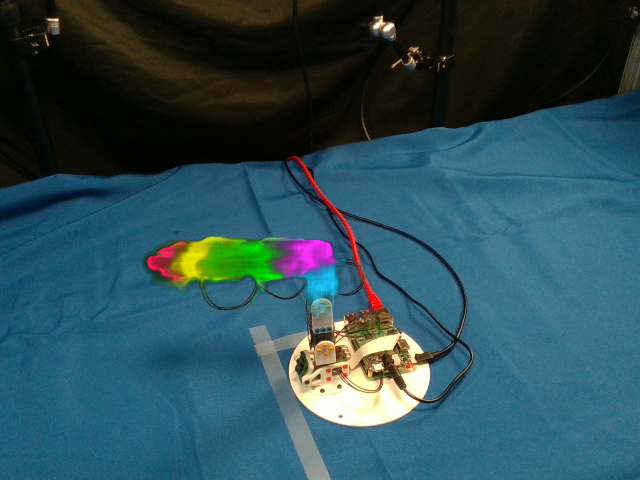

In [14]:
"""Visualize the jacobian chain structure"""
import mediapy as media
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

joint_sensitivity_np = joint_sensitivity_th.cpu().numpy()[0]

print(input_image_np.shape)
print(joint_sensitivity_np.shape)
print(jacobian_colormap.shape)

pred_jacobian_overlay_rgb, _ = visualize_jacobian_chain_structure(
    input_image_np=input_image_np,
    input_joint_sensitivity_np=joint_sensitivity_np,
    joint_colors_np=jacobian_colormap.cpu().numpy().T,
)
pred_jacobian_overlay_rgb = pred_jacobian_overlay_rgb[..., :3]

media.show_images(
 [
     pred_jacobian_overlay_rgb
 ]   
)
plt.imsave('jacobian_overlay.png', pred_jacobian_overlay_rgb)
